# Intro

# Text preprocessing

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import pandas as pd

np.random.seed(37)

def transform_text(text, stop_words, stemmer):
    def is_int(s):
        try: 
            int(s)
            return True
        except ValueError:
            return False
        
    tokens = word_tokenize(text.lower())
    tokens = filter(lambda t: len(t) > 2, tokens)
    tokens = filter(lambda t: t not in stop_words, tokens)
    tokens = filter(lambda t: is_int(t) is False, tokens)
    tokens = map(lambda t: stemmer.stem(t), tokens)
    return list(tokens)
    
prog_docs = [
    'Computer Programming for Beginners: Fundamentals of Programming Terms and Concepts',
    'Getting started with Julia Programming Language',
    'The Art of Computer Programming',
    'Computer Programming: Learn Any Programming Language In 2 Hours',
    'The Self-Taught Programmer: The Definitive Guide to Programming Professionally',
    'Computer Programming for Beginners: Fundamentals of Programming Terms and Concepts',
    'Computer Programming For Beginners: Learn The Basics of Java, SQL, C, C++, C#, Python, HTML, CSS and Javascript',
    'Code: The Hidden Language of Computer Hardware and Software (Developer Best Practices)',
    'Beginning Programming All-In-One Desk Reference For Dummies',
    'The Complete Software Developer\'s Career Guide: How to Learn Programming Languages Quickly, Ace Your Programming Interview',
    'C++17 STL Cookbook: Discover the latest enhancements to functional programming and lambda expressions',
    'Mathematics for Computer Graphics and Game Programming: A Self-Teaching Introduction',
    'Programming: This Book Includes: Machine Learning + Python Machine Learning + Python Programming',
    'Python Crash Course: Python Programming Is The Ultimate Crash Course To Programming With Python Coding Language Ideal To Learn Faster Computer Programming. the best Approach With Practical Exercises',
    'Python Programming: An Introduction to Computer Science, 3rd Ed.'
]
econ_docs = [
    'Basic Economics, Fifth Edition: A Common Sense Guide to the Economy',
    'The Cartoon Introduction to Economics: Volume Two: Macroeconomics',
    'The Cartoon Introduction to Economics: Volume One: Microeconomics',
    'Principles of Economics',
    'Introduction to Economics: Social Issues and Economic Thinking',
    'Schaum\'s Outline of Introduction to Mathematical Economics,',
    'Basic Economics: A Citizen\'s Guide to the Economy',
    'Markets, Games, and Strategic Behavior: An Introduction to Experimental Economics',
    'Economics Through Everyday Life: From China and Chili Dogs to Marx and Marijuana',
    'An Introduction To Law and Economics',
    'The Economics Book',
    'An Introduction to Mathematical Analysis for Economic Theory and Econometrics',
    'Introduction to Environmental Economics',
    'Introduction to Agricultural Economics',
    'Economic Geography: A Critical Introduction'
]
docs = prog_docs + econ_docs

n_prog = len(prog_docs)
n_econ = len(econ_docs)
print('num programming books = {}, number of economics book = {}, total = {}'.format(n_prog, n_econ, len(docs)))

tags = ('comp ' * n_prog).strip().split(' ') + ('econ ' * n_econ).strip().split(' ')
clazzes = np.hstack([np.full((1, n_prog), 0), np.full((1, n_econ), 1)])[0]

stop_words = set(stopwords.words('english')) 
stemmer = PorterStemmer()

documents = [TaggedDocument(transform_text(doc, stop_words, stemmer), [i, tag]) 
                 for i, (doc, tag) in enumerate(zip(docs, tags))]

print()
for doc in documents:
    print(doc)

num programming books = 15, number of economics book = 15, total = 30

TaggedDocument(['comput', 'program', 'beginn', 'fundament', 'program', 'term', 'concept'], [0, 'comp'])
TaggedDocument(['get', 'start', 'julia', 'program', 'languag'], [1, 'comp'])
TaggedDocument(['art', 'comput', 'program'], [2, 'comp'])
TaggedDocument(['comput', 'program', 'learn', 'program', 'languag', 'hour'], [3, 'comp'])
TaggedDocument(['self-taught', 'programm', 'definit', 'guid', 'program', 'profession'], [4, 'comp'])
TaggedDocument(['comput', 'program', 'beginn', 'fundament', 'program', 'term', 'concept'], [5, 'comp'])
TaggedDocument(['comput', 'program', 'beginn', 'learn', 'basic', 'java', 'sql', 'c++', 'python', 'html', 'css', 'javascript'], [6, 'comp'])
TaggedDocument(['code', 'hidden', 'languag', 'comput', 'hardwar', 'softwar', 'develop', 'best', 'practic'], [7, 'comp'])
TaggedDocument(['begin', 'program', 'all-in-on', 'desk', 'refer', 'dummi'], [8, 'comp'])
TaggedDocument(['complet', 'softwar', 'develo

# Learn document vectorization model

In [2]:
from sklearn.utils import shuffle
import multiprocessing
from tqdm import tqdm

cpu_count = multiprocessing.cpu_count()
vector_size = 5
alpha = 0.025

model = Doc2Vec(vector_size=vector_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=2,
                workers=cpu_count,
                dm=1)

model.build_vocab([d for d in tqdm(documents)])

max_epochs = 500

for epoch in range(max_epochs):
    model.train(shuffle([d for d in documents]), total_examples=model.corpus_count, epochs=model.epochs)
    model.alpha -= 0.0002
    model.min_alpha = model.alpha
    
model.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
print('done')

100%|██████████| 30/30 [00:00<00:00, 77148.45it/s]


done


# Visualize distributions

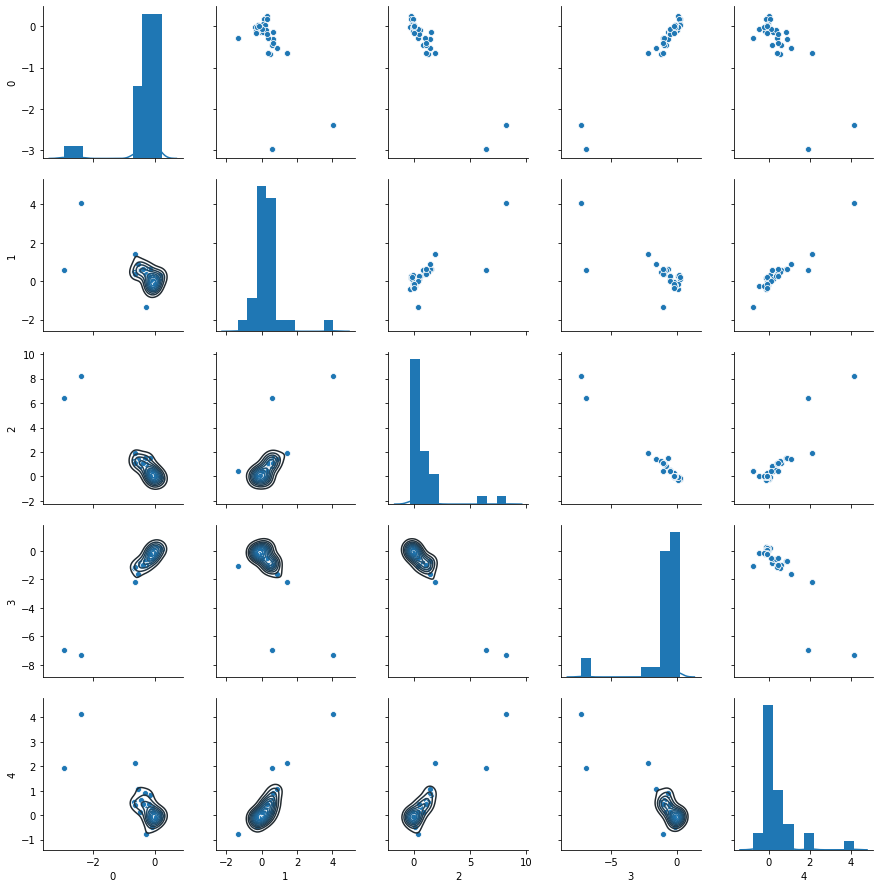

In [3]:
X = pd.DataFrame(np.array([model.docvecs[d] for d in range(len(model.docvecs))]))

g = sns.pairplot(X)
g.map_lower(sns.kdeplot, **{'shade': False, 'n_levels': 10})
g.map_upper(sns.scatterplot)
g.map_diag(sns.distplot, **{'hist': False, 'rug': False, 'kde': True})

# Visualize cosine similarity of document and inferred vectors

Text(0.5, 1, 'DocVecs vs InferredVecs')

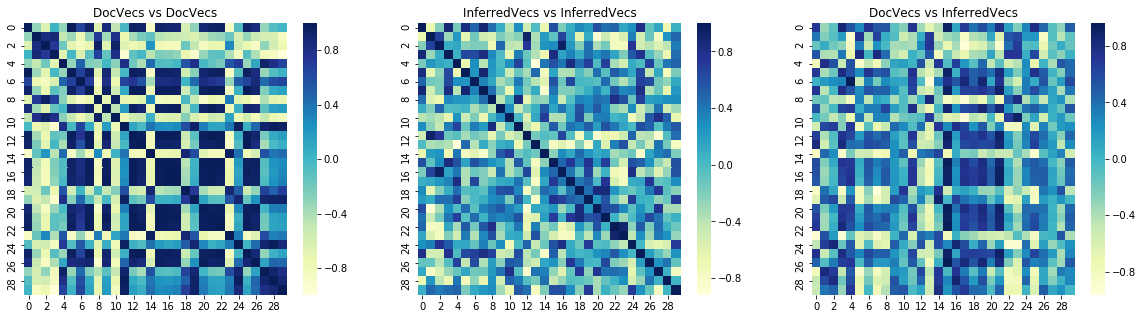

In [4]:
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity

X = np.array([model.docvecs[d.tags[0]] for d in documents], dtype=np.double)
Y = np.array([model.infer_vector(d.words, steps=200, alpha=0.025) for d in documents], dtype=np.double)

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

sns.heatmap(cosine_similarity(X, X), ax=ax[0], cmap='YlGnBu')
sns.heatmap(cosine_similarity(Y, Y), ax=ax[1], cmap='YlGnBu')
sns.heatmap(cosine_similarity(X, Y), ax=ax[2], cmap='YlGnBu')

ax[0].set_title('DocVecs vs DocVecs')
ax[1].set_title('InferredVecs vs InferredVecs')
ax[2].set_title('DocVecs vs InferredVecs')

In [5]:
similar_doc = model.docvecs.most_similar(0)
print(similar_doc)

[(5, 0.9953669309616089), ('comp', 0.9555094242095947), (22, 0.9516924619674683), (12, 0.9478724002838135), (25, 0.9374725818634033), (21, 0.9341868162155151), (15, 0.9315423965454102), (7, 0.9292193055152893), (13, 0.9256703853607178), (16, 0.9102708101272583)]


# Classification

In [6]:
H = [
    'Elements of Programming Interviews in Python The Insiders Guide', 
    'Programming: This Book Includes: Machine Learning + Python Machine Learning + Python Programming',
    'Naked Economics Undressing the Dismal Science',
    'An Introduction to Behavioral Economics'
]
H = [transform_text(h, stop_words, stemmer) for h in H]
H = [model.infer_vector(h, steps=200, alpha=0.025) for h in H]
H = np.array(H)

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score

lr = LogisticRegression(solver='lbfgs')
lr.fit(X, clazzes)
y_pred = lr.predict_proba(X)[:,1]

auc_roc = roc_auc_score(clazzes, y_pred)
auc_pr = average_precision_score(clazzes, y_pred)

print('roc = {:.5f}, pr = {:.5f}'.format(auc_roc, auc_pr))
print(lr.coef_)

roc = 0.74667, pr = 0.65379
[[-0.27952548 -0.50150437 -0.12013684 -0.20850828 -0.13098024]]


In [8]:
lr.predict_proba(H)

array([[0.51293213, 0.48706787],
       [0.49272447, 0.50727553],
       [0.49118029, 0.50881971],
       [0.50035728, 0.49964272]])

In [9]:
lr = LogisticRegression(solver='lbfgs')
lr.fit(Y, clazzes)
y_pred = lr.predict_proba(Y)[:,1]

auc_roc = roc_auc_score(clazzes, y_pred)
auc_pr = average_precision_score(clazzes, y_pred)

print('roc = {:.5f}, pr = {:.5f}'.format(auc_roc, auc_pr))
print(lr.coef_)

roc = 0.68000, pr = 0.69143
[[-0.26486974  0.04377964  0.20742981 -0.19031835  0.02242126]]


In [10]:
lr.predict_proba(H)

array([[0.50568002, 0.49431998],
       [0.50540707, 0.49459293],
       [0.50067128, 0.49932872],
       [0.49922251, 0.50077749]])

In [11]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=20)
rf.fit(Y, clazzes)
y_pred = rf.predict_proba(Y)[:,1]

auc_roc = roc_auc_score(clazzes, y_pred)
auc_pr = average_precision_score(clazzes, y_pred)

print('roc = {:.5f}, pr = {:.5f}'.format(auc_roc, auc_pr))

rf.predict_proba(H)

roc = 1.00000, pr = 1.00000


array([[0.95, 0.05],
       [0.8 , 0.2 ],
       [0.5 , 0.5 ],
       [0.5 , 0.5 ]])

# Explain

In [12]:
import shap

shap.initjs()

Z = pd.DataFrame(Y, columns=['x{}'.format(i) for i in range(Y.shape[1])])
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(Z)

In [13]:
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], Z.iloc[0,:])

In [14]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], Z.iloc[0,:])

In [15]:
shap.force_plot(explainer.expected_value[0], shap_values[0], Z)

In [16]:
shap.force_plot(explainer.expected_value[1], shap_values[1], Z)

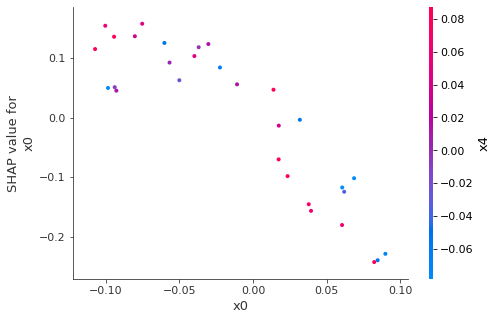

In [17]:
shap.dependence_plot('x0', shap_values[1], Z)

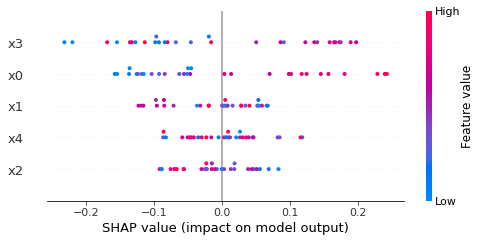

In [18]:
shap.summary_plot(shap_values[0], Z)

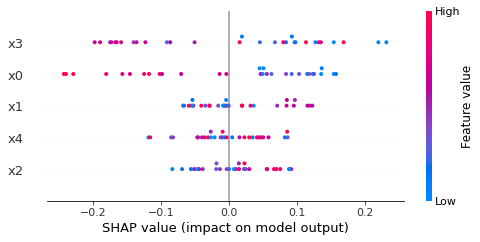

In [19]:
shap.summary_plot(shap_values[1], Z)

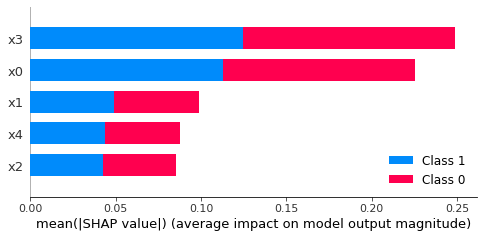

In [20]:
shap.summary_plot(shap_values, Z)